In [1]:
#import torch
import os, sys, re, time
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

511394


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20240401-Merscope01_s11_n1200'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation
/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed


In [6]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [8]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_MF5_v2.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5
-- 12 folders, 730 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Analysis/color_usage_MF5_v2.csv


In [9]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '637', 'hyb': 'H11M12'} 477


# Run segmentation

In [10]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d
from merlin.analysis.segment import CellPoseSegment

In [11]:
from importlib import reload

In [12]:
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [13]:

for _fov_id, _fov_name in enumerate(fovs):


    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    #_ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls.ref_correction_channel = '637'
    #_cls._corr_illumination()
    _cls._calculate_drift(_ref_im, )
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    
    _dapi_im = getattr(_ref_cls, f"im_{dapi_info['channel']}")
    _polyt_im = getattr(_cls, f"im_{polyt_info['channel']}")
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1200/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=50, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

        # save this segmentation mask
        print(f"- save to {np.max(corr_labels3d)} labels to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    
    

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_000.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_000.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.403s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_000_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.076s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.970s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_005.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_005_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.542s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  7.51 -5.91] in 0.518s.
-- drift 1: [ 0.02  8.46 -5.94] in 0.453s.
-- drift 2: [-0.03  9.15 -5.71] in 0.470s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.743s.
- Finished warp correction in 8.743s.
- apply microscope corrections
- run Cellpose segmentation in 35.619s.
- save to 101 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.315s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    8.26 -7.01] in 0.543s.
-- drift 1: [ 0.    8.44 -6.86] in 0.476s.
-- drift 2: [-0.01  8.64 -6.67] in 0.480s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.822s.
- Finished warp correction in 8.822s.
- apply microscope corrections
- run Cellpose segmentation in 36.797s.
- save to 97 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_10.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_011.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_011.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/

-- drift 0: [-0.01  8.41 -7.13] in 0.541s.
-- drift 1: [ 0.    8.28 -7.2 ] in 0.512s.
-- drift 2: [-0.01  8.72 -7.42] in 0.501s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.907s.
- Finished warp correction in 8.908s.
- apply microscope corrections
- run Cellpose segmentation in 34.702s.
- save to 61 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_15.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_016.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_016.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_016.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_016_processed.hd

-- corrected warp for channel 637 in 8.893s.
- Finished warp correction in 8.893s.
- apply microscope corrections
- run Cellpose segmentation in 38.755s.
- save to 96 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_20.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_021.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_021.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_021.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_021_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.168s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_021.dax
- New save file:

- run Cellpose segmentation in 41.677s.
- save to 133 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_25.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_026.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_026.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_026.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_026_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.405s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_026.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_026_processed.hdf5
-- all used cha

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_031.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_031.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_031.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_031_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.867s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_031.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_031_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.036s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.812s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_036.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_036_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.910s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  8.45 -7.5 ] in 0.519s.
-- drift 1: [ 0.    8.34 -7.62] in 0.465s.
-- drift 2: [ 0.    8.34 -7.5 ] in 0.475s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.763s.
- Finished warp correction in 8.763s.
- apply microscope corrections
- run Cellpose segmentation in 39.251s.
- save to 130 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.191s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  8.14 -7.01] in 0.593s.
-- drift 1: [-0.01  8.05 -7.  ] in 0.470s.
-- drift 2: [ 0.    8.03 -7.07] in 0.477s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.984s.
- Finished warp correction in 8.984s.
- apply microscope corrections
- run Cellpose segmentation in 40.151s.
- save to 130 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_41.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_042.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_042.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng

-- drift 0: [-0.01  8.32 -7.82] in 0.536s.
-- drift 1: [-0.01  8.25 -7.83] in 0.477s.
-- drift 2: [-0.01  8.28 -7.76] in 0.477s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.921s.
- Finished warp correction in 8.922s.
- apply microscope corrections
- run Cellpose segmentation in 34.902s.
- save to 84 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_46.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_047.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_047.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_047.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_047_processed.hd

-- corrected warp for channel 637 in 8.921s.
- Finished warp correction in 8.921s.
- apply microscope corrections
- run Cellpose segmentation in 31.562s.
- save to 22 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_51.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_052.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_052.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_052.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_052_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.647s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_052.dax
- New save file:

- run Cellpose segmentation in 43.280s.
- save to 186 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_56.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_057.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_057.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_057.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_057_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.946s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_057.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_057_processed.hdf5
-- all used cha

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_062.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_062.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_062.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_062_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.958s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_062.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_062_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.972s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 2.001s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_067.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_067_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.119s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.29 -7.58] in 0.534s.
-- drift 1: [ 0.    6.23 -7.52] in 0.481s.
-- drift 2: [ 0.   6.3 -7.5] in 0.479s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.109s.
- Finished warp correction in 9.109s.
- apply microscope corrections
- run Cellpose segmentation in 38.750s.
- save to 129 labels to file: /lab/weis

- Loaded images for channels:['637', '477'] in 1.098s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  6.82 -7.46] in 0.543s.
-- drift 1: [ 0.    6.83 -7.46] in 0.482s.
-- drift 2: [ 0.    6.81 -7.45] in 0.469s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.892s.
- Finished warp correction in 8.892s.
- apply microscope corrections
- run Cellpose segmentation in 35.922s.
- save to 102 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_72.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_073.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_073.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng

-- drift 0: [-0.01  7.58 -7.17] in 0.524s.
-- drift 1: [-0.01  7.5  -7.19] in 0.469s.
-- drift 2: [-0.01  7.51 -7.2 ] in 0.476s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.862s.
- Finished warp correction in 8.862s.
- apply microscope corrections
- run Cellpose segmentation in 38.085s.
- save to 120 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_77.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_078.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_078.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_078.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_078_processed.h

-- corrected warp for channel 637 in 8.707s.
- Finished warp correction in 8.707s.
- apply microscope corrections
- run Cellpose segmentation in 39.509s.
- save to 126 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_82.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_083.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_083.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_083.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_083_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.122s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_083.dax
- New save file

- run Cellpose segmentation in 37.779s.
- save to 135 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_87.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_088.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_088.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_088.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_088_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.885s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_088.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_088_processed.hdf5
-- all used cha

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_093.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_093.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_093.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_093_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.860s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_093.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_093_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.224s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.845s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_098.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_098_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.066s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    7.38 -6.76] in 0.544s.
-- drift 1: [-0.01  7.35 -6.64] in 0.488s.
-- drift 2: [ 0.    7.42 -6.87] in 0.487s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.902s.
- Finished warp correction in 8.902s.
- apply microscope corrections
- run Cellpose segmentation in 35.208s.
- save to 92 labels to file: /lab/we

- Loaded images for channels:['637', '477'] in 1.180s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    7.67 -8.47] in 0.518s.
-- drift 1: [ 0.    7.63 -8.35] in 0.490s.
-- drift 2: [ 0.    7.69 -8.37] in 0.546s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.900s.
- Finished warp correction in 8.900s.
- apply microscope corrections
- run Cellpose segmentation in 39.591s.
- save to 172 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_103.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_104.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_104.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [ 0.    7.92 -6.25] in 0.537s.
-- drift 1: [ 0.    8.03 -6.4 ] in 0.490s.
-- drift 2: [ 0.    8.14 -6.35] in 0.482s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.071s.
- Finished warp correction in 9.072s.
- apply microscope corrections
- run Cellpose segmentation in 40.236s.
- save to 168 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_108.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_109.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_109.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_109.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_109_processed.

-- drift 2: [ 0.    6.01 -8.25] in 0.489s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.902s.
- Finished warp correction in 8.902s.
- apply microscope corrections
- run Cellpose segmentation in 39.129s.
- save to 108 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_113.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_114.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_114.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_114.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_114_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.926s.
- Finished warp correction in 8.926s.
- apply microscope corrections
- run Cellpose segmentation in 36.413s.
- save to 138 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_118.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_119.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_119.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_119.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_119_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.980s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_119.dax
- New save fil

- run Cellpose segmentation in 39.535s.
- save to 147 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_123.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_124.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_124.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_124.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_124_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.861s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_124.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_124_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_129.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_129.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_129.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_129_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.873s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_129.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_129_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.044s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.899s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_134.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_134_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.087s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    8.22 -6.58] in 0.539s.
-- drift 1: [-0.01  8.15 -6.64] in 0.490s.
-- drift 2: [ 0.    8.2  -6.59] in 0.471s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.334s.
- Finished warp correction in 9.335s.
- apply microscope corrections
- run Cellpose segmentation in 38.981s.
- save to 138 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.059s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  8.13 -5.57] in 0.553s.
-- drift 1: [-0.02  8.01 -5.44] in 0.500s.
-- drift 2: [-0.01  8.35 -5.53] in 0.484s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.911s.
- Finished warp correction in 8.911s.
- apply microscope corrections
- run Cellpose segmentation in 38.377s.
- save to 186 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_139.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_140.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_140.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [ 0.    8.01 -5.95] in 0.549s.
-- drift 1: [ 0.    7.95 -5.91] in 0.483s.
-- drift 2: [ 0.    8.05 -6.03] in 0.490s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.815s.
- Finished warp correction in 8.815s.
- apply microscope corrections
- run Cellpose segmentation in 37.828s.
- save to 146 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_144.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_145.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_145.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_145.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_145_processed.

-- drift 2: [-0.01  6.84 -7.91] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.871s.
- Finished warp correction in 8.871s.
- apply microscope corrections
- run Cellpose segmentation in 40.873s.
- save to 145 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_149.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_150.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_150.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_150.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_150_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.893s.
- Finished warp correction in 8.893s.
- apply microscope corrections
- run Cellpose segmentation in 39.197s.
- save to 117 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_154.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_155.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_155.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_155.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_155_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.856s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_155.dax
- New save fil

- run Cellpose segmentation in 38.020s.
- save to 96 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_159.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_160.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_160.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_160.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_160_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.023s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_160.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_160_processed.hdf5
-- all used cha

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_165.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_165.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_165.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_165_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.186s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_165.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_165_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.100s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.880s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_170.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_170_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.951s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.35 -6.44] in 0.535s.
-- drift 1: [-0.03  6.15 -6.08] in 0.564s.
-- drift 2: [ 0.    6.15 -6.9 ] in 0.486s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.991s.
- Finished warp correction in 8.991s.
- apply microscope corrections
- run Cellpose segmentation in 38.851s.
- save to 118 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.027s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    7.1  -6.35] in 0.556s.
-- drift 1: [-0.01  6.97 -6.31] in 0.482s.
-- drift 2: [ 0.    7.01 -6.46] in 0.487s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.780s.
- Finished warp correction in 8.780s.
- apply microscope corrections
- run Cellpose segmentation in 37.922s.
- save to 142 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_175.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_176.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_176.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [-0.01  8.56 -7.26] in 0.573s.
-- drift 1: [ 0.    8.52 -7.3 ] in 0.504s.
-- drift 2: [ 0.    8.53 -7.37] in 0.493s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.886s.
- Finished warp correction in 8.886s.
- apply microscope corrections
- run Cellpose segmentation in 38.485s.
- save to 161 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_180.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_181.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_181.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_181.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_181_processed.

-- drift 2: [-0.01  7.29 -5.82] in 0.476s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.882s.
- Finished warp correction in 8.882s.
- apply microscope corrections
- run Cellpose segmentation in 38.227s.
- save to 132 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_185.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_186.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_186.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_186.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_186_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.883s.
- Finished warp correction in 8.883s.
- apply microscope corrections
- run Cellpose segmentation in 38.699s.
- save to 180 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_190.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_191.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_191.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_191.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_191_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.851s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_191.dax
- New save fil

- run Cellpose segmentation in 37.130s.
- save to 144 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_195.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_196.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_196.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_196.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_196_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.941s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_196.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_196_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_201.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_201.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_201.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_201_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.814s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_201.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_201_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.044s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.970s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_206.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_206_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.291s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  5.41 -7.54] in 0.507s.
-- drift 1: [ 0.    5.45 -7.5 ] in 0.501s.
-- drift 2: [ 0.    5.49 -7.45] in 0.496s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.929s.
- Finished warp correction in 8.929s.
- apply microscope corrections
- run Cellpose segmentation in 39.078s.
- save to 112 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.284s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.79 -6.02] in 0.557s.
-- drift 1: [ 0.    6.67 -6.06] in 0.511s.
-- drift 2: [ 0.    6.72 -6.09] in 0.492s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.852s.
- Finished warp correction in 8.852s.
- apply microscope corrections
- run Cellpose segmentation in 37.367s.
- save to 85 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_211.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_212.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_212.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng

-- drift 0: [-0.01  5.79 -5.77] in 0.547s.
-- drift 1: [ 0.    6.18 -5.9 ] in 0.489s.
-- drift 2: [ 0.02  6.99 -6.1 ] in 0.483s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.497s.
- Finished warp correction in 9.497s.
- apply microscope corrections
- run Cellpose segmentation in 37.012s.
- save to 131 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_216.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_217.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_217.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_217.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_217_processed.

-- drift 2: [ 0.    7.37 -6.09] in 0.401s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.885s.
- Finished warp correction in 8.885s.
- apply microscope corrections
- run Cellpose segmentation in 37.490s.
- save to 145 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_221.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_222.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_222.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_222.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_222_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.901s.
- Finished warp correction in 8.901s.
- apply microscope corrections
- run Cellpose segmentation in 39.639s.
- save to 186 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_226.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_227.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_227.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_227.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_227_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.980s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_227.dax
- New save fil

- run Cellpose segmentation in 34.253s.
- save to 78 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_231.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_232.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_232.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_232.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_232_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.777s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_232.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_232_processed.hdf5
-- all used cha

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_237.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_237.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_237.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_237_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.822s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_237.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_237_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.037s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.857s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_242.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_242_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.112s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.31 -6.08] in 0.541s.
-- drift 1: [ 0.    6.18 -5.85] in 0.491s.
-- drift 2: [ 0.    6.09 -6.08] in 0.485s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.868s.
- Finished warp correction in 8.868s.
- apply microscope corrections
- run Cellpose segmentation in 37.791s.
- save to 152 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.084s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.03  4.96 -5.77] in 0.581s.
-- drift 1: [ 0.01  5.99 -6.12] in 0.519s.
-- drift 2: [-1.0000e-02  1.1241e+02 -5.7270e+01] in 0.490s.
-- drift 3: [ 0.    5.68 -5.57] in 0.493s.
-- drift 4: [ 0.01  6.24 -5.3 ] in 0.490s.
-- drift 5: [ 0.    5.77 -5.56] in 0.494s.
-- drift 6: [-0.01  5.32 -5.86] in 0.495s.
-- drift 7: [-1.000e-02  2.681e+01 -5.801e+01] in 0.488s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.810s.
- Finished warp correction in 8.810s.
- apply microscope corrections
- run Cellpose segmentation in 35.623s.
- save to 108 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_247.npy
reference image: /lab/weissman_imaging/puzheng/msBra

- Loaded images for channels:['637', '477'] in 1.100s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.02  5.52 -8.59] in 0.658s.
-- drift 1: [ 0.    5.5  -8.62] in 0.497s.
-- drift 2: [ 0.    5.48 -8.61] in 0.491s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.331s.
- Finished warp correction in 9.332s.
- apply microscope corrections
- run Cellpose segmentation in 35.656s.
- save to 95 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_252.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_253.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_253.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng

-- drift 0: [ 0.    6.21 -6.02] in 0.560s.
-- drift 1: [-0.01  6.09 -5.99] in 0.491s.
-- drift 2: [-0.01  6.06 -6.03] in 0.491s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.771s.
- Finished warp correction in 8.771s.
- apply microscope corrections
- run Cellpose segmentation in 36.549s.
- save to 77 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_257.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_258.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_258.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_258.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_258_processed.h

-- drift 2: [ 0.01  6.06 -5.84] in 0.485s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.871s.
- Finished warp correction in 8.872s.
- apply microscope corrections
- run Cellpose segmentation in 34.934s.
- save to 112 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_262.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_263.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_263.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_263.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_263_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.760s.
- Finished warp correction in 8.760s.
- apply microscope corrections
- run Cellpose segmentation in 38.393s.
- save to 160 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_267.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_268.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_268.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_268.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_268_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.914s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_268.dax
- New save fil

- run Cellpose segmentation in 38.101s.
- save to 170 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_272.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_273.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_273.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_273.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_273_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.788s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_273.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_273_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_278.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_278.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_278.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_278_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.781s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_278.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_278_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.071s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.746s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_283.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_283_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.010s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.89 -6.78] in 0.538s.
-- drift 1: [ 0.    6.79 -6.8 ] in 0.476s.
-- drift 2: [ 0.    6.91 -6.77] in 0.479s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.767s.
- Finished warp correction in 8.767s.
- apply microscope corrections
- run Cellpose segmentation in 38.323s.
- save to 163 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.055s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    7.09 -5.58] in 0.554s.
-- drift 1: [ 0.    7.02 -5.59] in 0.488s.
-- drift 2: [ 0.    7.02 -5.56] in 0.483s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.759s.
- Finished warp correction in 8.759s.
- apply microscope corrections
- run Cellpose segmentation in 37.032s.
- save to 173 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_288.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_289.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_289.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [ 0.01  6.2  -7.5 ] in 0.535s.
-- drift 1: [ 0.    6.39 -7.1 ] in 0.456s.
-- drift 2: [ 0.    6.12 -7.17] in 0.459s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.775s.
- Finished warp correction in 8.775s.
- apply microscope corrections
- run Cellpose segmentation in 34.695s.
- save to 113 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_293.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_294.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_294.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_294.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_294_processed.

-- drift 2: [ 0.01  4.94 -5.71] in 0.491s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.869s.
- Finished warp correction in 8.869s.
- apply microscope corrections
- run Cellpose segmentation in 37.677s.
- save to 97 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_298.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_299.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_299.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_299.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_299_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 230

-- corrected warp for channel 637 in 8.888s.
- Finished warp correction in 8.888s.
- apply microscope corrections
- run Cellpose segmentation in 36.904s.
- save to 110 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_303.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_304.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_304.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_304.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_304_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.847s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_304.dax
- New save fil

- run Cellpose segmentation in 39.562s.
- save to 159 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_308.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_309.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_309.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_309.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_309_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.770s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_309.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_309_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_314.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_314.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_314.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_314_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.817s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_314.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_314_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.043s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.836s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_319.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_319_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.034s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  7.15 -5.22] in 0.495s.
-- drift 1: [-0.01  6.96 -5.23] in 0.437s.
-- drift 2: [-0.01  6.97 -5.34] in 0.439s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.781s.
- Finished warp correction in 8.781s.
- apply microscope corrections
- run Cellpose segmentation in 37.858s.
- save to 158 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.139s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    5.83 -4.86] in 0.542s.
-- drift 1: [ 0.    5.74 -4.99] in 0.493s.
-- drift 2: [ 0.    5.8  -4.82] in 0.495s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.924s.
- Finished warp correction in 8.924s.
- apply microscope corrections
- run Cellpose segmentation in 36.245s.
- save to 159 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_324.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_325.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_325.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [-0.01  6.82 -6.78] in 0.516s.
-- drift 1: [-0.01  6.75 -6.81] in 0.515s.
-- drift 2: [ 0.   6.7 -6.8] in 0.480s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.847s.
- Finished warp correction in 8.847s.
- apply microscope corrections
- run Cellpose segmentation in 37.940s.
- save to 156 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_329.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_330.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_330.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_330.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_330_processed.hdf

-- drift 2: [ 0.    6.62 -5.42] in 0.484s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.630s.
- Finished warp correction in 9.631s.
- apply microscope corrections
- run Cellpose segmentation in 41.191s.
- save to 184 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_334.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_335.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_335.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_335.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_335_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.866s.
- Finished warp correction in 8.867s.
- apply microscope corrections
- run Cellpose segmentation in 39.995s.
- save to 156 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_339.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_340.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_340.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_340.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_340_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.794s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_340.dax
- New save fil

-- corrected warp for channel 637 in 8.852s.
- Finished warp correction in 8.852s.
- apply microscope corrections
- run Cellpose segmentation in 37.121s.
- save to 116 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_344.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_345.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_345.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_345.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_345_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.875s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_345.dax
- New save fil

- run Cellpose segmentation in 38.345s.
- save to 100 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_349.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_350.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_350.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_350.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_350_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.991s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_350.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_350_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_355.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_355.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_355.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_355_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.075s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_355.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_355_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.059s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.888s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_360.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_360_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.124s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  6.46 -5.21] in 0.539s.
-- drift 1: [-0.01  6.36 -5.31] in 0.488s.
-- drift 2: [-0.01  6.29 -5.38] in 0.479s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.764s.
- Finished warp correction in 8.764s.
- apply microscope corrections
- run Cellpose segmentation in 36.879s.
- save to 135 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 0.994s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  7.3  -4.38] in 0.544s.
-- drift 1: [ 0.    7.25 -4.28] in 0.486s.
-- drift 2: [-0.01  7.25 -4.28] in 0.484s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.888s.
- Finished warp correction in 8.888s.
- apply microscope corrections
- run Cellpose segmentation in 37.143s.
- save to 149 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_365.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_366.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_366.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [ 0.    7.22 -7.36] in 0.545s.
-- drift 1: [ 0.15  6.95 -7.61] in 0.554s.
-- drift 2: [ 0.    7.4  -6.88] in 0.474s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.849s.
- Finished warp correction in 8.850s.
- apply microscope corrections
- run Cellpose segmentation in 32.133s.
- save to 44 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_370.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_371.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_371.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_371.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_371_processed.h

-- drift 2: [-0.01  6.15 -7.33] in 0.469s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.880s.
- Finished warp correction in 8.880s.
- apply microscope corrections
- run Cellpose segmentation in 36.907s.
- save to 182 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_375.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_376.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_376.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_376.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_376_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.863s.
- Finished warp correction in 8.864s.
- apply microscope corrections
- run Cellpose segmentation in 38.236s.
- save to 136 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_380.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_381.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_381.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_381.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_381_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.840s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_381.dax
- New save fil

- run Cellpose segmentation in 35.735s.
- save to 146 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_385.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_386.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_386.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_386.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_386_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.771s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_386.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_386_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_391.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_391.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_391.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_391_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.835s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_391.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_391_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.093s.
+ Calculate drift with fiducial_channel: 477
-- start

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_396.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_396.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_396.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_396_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.703s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_396.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_396_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.171s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.682s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_401.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_401_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.034s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.76 -4.38] in 0.555s.
-- drift 1: [ 0.    6.67 -4.3 ] in 0.496s.
-- drift 2: [ 0.    6.65 -4.32] in 0.497s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.880s.
- Finished warp correction in 8.880s.
- apply microscope corrections
- run Cellpose segmentation in 37.267s.
- save to 125 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.110s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.37 -4.82] in 0.552s.
-- drift 1: [-0.01  6.36 -4.83] in 0.499s.
-- drift 2: [-0.01  6.26 -4.87] in 0.487s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.899s.
- Finished warp correction in 8.899s.
- apply microscope corrections
- run Cellpose segmentation in 38.891s.
- save to 141 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_406.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_407.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_407.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [-0.03  6.81 -5.32] in 0.559s.
-- drift 1: [-0.01  6.74 -5.5 ] in 0.499s.
-- drift 2: [-0.01  6.79 -5.22] in 0.499s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.896s.
- Finished warp correction in 8.896s.
- apply microscope corrections
- run Cellpose segmentation in 40.542s.
- save to 184 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_411.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_412.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_412.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_412.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_412_processed.

-- drift 2: [-0.01  6.04 -4.81] in 0.497s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.911s.
- Finished warp correction in 8.911s.
- apply microscope corrections
- run Cellpose segmentation in 42.441s.
- save to 232 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_416.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_417.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_417.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_417.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_417_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.731s.
- Finished warp correction in 8.731s.
- apply microscope corrections
- run Cellpose segmentation in 38.464s.
- save to 133 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_421.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_422.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_422.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_422.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_422_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.714s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_422.dax
- New save fil

- run Cellpose segmentation in 42.117s.
- save to 236 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_426.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_427.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_427.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_427.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_427_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.967s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_427.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_427_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_432.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_432.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_432.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_432_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.004s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_432.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_432_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.019s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.685s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_437.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_437_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.007s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    5.82 -5.34] in 0.534s.
-- drift 1: [ 0.    5.73 -5.45] in 0.477s.
-- drift 2: [ 0.    5.77 -5.5 ] in 0.477s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.880s.
- Finished warp correction in 8.880s.
- apply microscope corrections
- run Cellpose segmentation in 39.758s.
- save to 141 labels to file: /lab/w

- Loaded images for channels:['477', '405'] in 1.695s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_442.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_442_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.074s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    4.71 -4.59] in 0.560s.
-- drift 1: [ 0.    5.   -4.46] in 0.496s.
-- drift 2: [ 0.01  4.28 -4.25] in 0.490s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.859s.
- Finished warp correction in 8.859s.
- apply microscope corrections
- run Cellpose segmentation in 32.914s.
- save to 60 labels to file: /lab/we

- Loaded images for channels:['477', '405'] in 1.762s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_447.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_447_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.004s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.03 -5.62] in 0.547s.
-- drift 1: [ 0.    5.98 -5.55] in 0.493s.
-- drift 2: [ 0.    6.03 -5.6 ] in 0.494s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.141s.
- Finished warp correction in 9.141s.
- apply microscope corrections
- run Cellpose segmentation in 40.054s.
- save to 112 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.247s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  6.04 -5.26] in 0.584s.
-- drift 1: [ 0.    6.13 -5.56] in 0.473s.
-- drift 2: [-0.01  5.88 -5.26] in 0.480s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.865s.
- Finished warp correction in 8.865s.
- apply microscope corrections
- run Cellpose segmentation in 34.290s.
- save to 104 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_452.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_453.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_453.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [-0.01  6.01 -5.22] in 0.505s.
-- drift 1: [-0.01  6.1  -4.89] in 0.486s.
-- drift 2: [ 0.    6.32 -4.87] in 0.484s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.892s.
- Finished warp correction in 8.892s.
- apply microscope corrections
- run Cellpose segmentation in 40.915s.
- save to 221 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_457.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_458.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_458.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_458.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_458_processed.

-- drift 2: [ 0.    6.29 -3.41] in 0.491s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.767s.
- Finished warp correction in 8.767s.
- apply microscope corrections
- run Cellpose segmentation in 39.539s.
- save to 164 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_462.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_463.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_463.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_463.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_463_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.877s.
- Finished warp correction in 8.877s.
- apply microscope corrections
- run Cellpose segmentation in 38.680s.
- save to 142 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_467.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_468.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_468.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_468.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_468_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.742s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_468.dax
- New save fil

- run Cellpose segmentation in 36.123s.
- save to 116 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_472.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_473.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_473.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_473.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_473_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.958s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_473.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_473_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_478.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_478.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_478.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_478_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.722s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_478.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_478_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.121s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.787s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_483.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_483_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.330s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.34 -3.74] in 0.538s.
-- drift 1: [-0.01  5.89 -3.99] in 0.481s.
-- drift 2: [ 0.    5.84 -3.79] in 0.481s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.866s.
- Finished warp correction in 8.866s.
- apply microscope corrections
- run Cellpose segmentation in 40.573s.
- save to 203 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.069s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    5.61 -4.44] in 0.543s.
-- drift 1: [ 0.    5.67 -4.4 ] in 0.479s.
-- drift 2: [ 0.    5.74 -4.46] in 0.472s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.878s.
- Finished warp correction in 8.878s.
- apply microscope corrections
- run Cellpose segmentation in 39.619s.
- save to 160 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_488.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_489.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_489.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [ 0.01  5.1  -5.23] in 0.536s.
-- drift 1: [ 0.    4.98 -5.15] in 0.477s.
-- drift 2: [ 0.01  5.36 -5.25] in 0.475s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.689s.
- Finished warp correction in 8.689s.
- apply microscope corrections
- run Cellpose segmentation in 32.634s.
- save to 60 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_493.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_494.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_494.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_494.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_494_processed.h

-- drift 2: [ 0.    6.16 -3.78] in 0.416s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.864s.
- Finished warp correction in 8.864s.
- apply microscope corrections
- run Cellpose segmentation in 38.097s.
- save to 138 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_498.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_499.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_499.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_499.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_499_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.901s.
- Finished warp correction in 8.901s.
- apply microscope corrections
- run Cellpose segmentation in 37.372s.
- save to 130 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_503.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_504.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_504.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_504.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_504_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.863s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_504.dax
- New save fil

- run Cellpose segmentation in 38.904s.
- save to 168 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_508.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_509.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_509.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_509.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_509_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.774s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_509.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_509_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_514.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_514.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_514.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_514_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.755s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_514.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_514_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.139s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.951s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_519.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_519_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.085s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    5.95 -4.1 ] in 0.542s.
-- drift 1: [ 0.08  5.69 -4.41] in 0.488s.
-- drift 2: [ 0.    5.97 -4.1 ] in 0.490s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.865s.
- Finished warp correction in 8.865s.
- apply microscope corrections
- run Cellpose segmentation in 31.868s.
- save to 38 labels to file: /lab/we

- Loaded images for channels:['637', '477'] in 1.034s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  5.51 -3.34] in 0.570s.
-- drift 1: [ 0.    5.49 -3.38] in 0.516s.
-- drift 2: [ 0.    5.54 -3.29] in 0.484s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.878s.
- Finished warp correction in 8.878s.
- apply microscope corrections
- run Cellpose segmentation in 37.841s.
- save to 145 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_524.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_525.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_525.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [ 0.    5.97 -5.09] in 0.530s.
-- drift 1: [ 0.    5.97 -4.87] in 0.471s.
-- drift 2: [ 0.    6.   -5.09] in 0.478s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.865s.
- Finished warp correction in 8.865s.
- apply microscope corrections
- run Cellpose segmentation in 39.853s.
- save to 179 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_529.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_530.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_530.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_530.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_530_processed.

-- drift 2: [ 0.    5.07 -3.95] in 0.481s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.882s.
- Finished warp correction in 8.882s.
- apply microscope corrections
- run Cellpose segmentation in 39.183s.
- save to 167 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_534.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_535.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_535.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_535.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_535_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.943s.
- Finished warp correction in 8.943s.
- apply microscope corrections
- run Cellpose segmentation in 38.641s.
- save to 154 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_539.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_540.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_540.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_540.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_540_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.745s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_540.dax
- New save fil

- run Cellpose segmentation in 33.900s.
- save to 86 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_544.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_545.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_545.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_545.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_545_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.734s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_545.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_545_processed.hdf5
-- all used cha

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_550.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_550.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_550.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_550_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.804s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_550.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_550_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.988s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.915s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_555.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_555_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.170s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  4.98 -4.63] in 0.519s.
-- drift 1: [-0.01  4.94 -4.61] in 0.475s.
-- drift 2: [ 0.    5.11 -4.61] in 0.473s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.957s.
- Finished warp correction in 8.957s.
- apply microscope corrections
- run Cellpose segmentation in 36.828s.
- save to 146 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 0.946s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  5.11 -4.46] in 0.567s.
-- drift 1: [ 0.    5.13 -4.52] in 0.459s.
-- drift 2: [ 0.    5.2  -4.52] in 0.491s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.930s.
- Finished warp correction in 8.930s.
- apply microscope corrections
- run Cellpose segmentation in 39.644s.
- save to 181 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_560.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_561.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_561.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [-0.01  5.43 -3.12] in 0.496s.
-- drift 1: [ 0.    5.43 -3.14] in 0.440s.
-- drift 2: [ 0.    5.41 -3.08] in 0.446s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.966s.
- Finished warp correction in 8.966s.
- apply microscope corrections
- run Cellpose segmentation in 39.319s.
- save to 160 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_565.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_566.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_566.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_566.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_566_processed.

-- drift 2: [ 0.11  3.88 -3.25] in 0.468s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.847s.
- Finished warp correction in 8.847s.
- apply microscope corrections
- run Cellpose segmentation in 32.137s.
- save to 25 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_570.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_571.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_571.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_571.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_571_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 230

-- corrected warp for channel 637 in 8.868s.
- Finished warp correction in 8.868s.
- apply microscope corrections
- run Cellpose segmentation in 37.163s.
- save to 103 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_575.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_576.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_576.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_576.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_576_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.120s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_576.dax
- New save fil

- run Cellpose segmentation in 38.765s.
- save to 172 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_580.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_581.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_581.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_581.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_581_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.680s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_581.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_581_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_586.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_586.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_586.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_586_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.822s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_586.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_586_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.061s.
+ Calculate drift with fiducial_channel: 477
-- start

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_591.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_591.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_591.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_591_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.795s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_591.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_591_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.093s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.935s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_596.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_596_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.073s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  5.56 -4.56] in 0.508s.
-- drift 1: [ 0.    4.89 -4.65] in 0.445s.
-- drift 2: [ 0.    5.21 -4.74] in 0.445s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.941s.
- Finished warp correction in 8.941s.
- apply microscope corrections
- run Cellpose segmentation in 35.774s.
- save to 105 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.182s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  5.28 -3.96] in 0.539s.
-- drift 1: [ 0.    5.25 -4.14] in 0.471s.
-- drift 2: [ 0.    5.34 -4.  ] in 0.472s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.790s.
- Finished warp correction in 8.790s.
- apply microscope corrections
- run Cellpose segmentation in 37.547s.
- save to 146 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_601.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_602.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_602.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [-0.01  5.72 -3.56] in 0.545s.
-- drift 1: [-0.01  5.73 -3.57] in 0.486s.
-- drift 2: [ 0.    5.78 -3.42] in 0.494s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.898s.
- Finished warp correction in 8.898s.
- apply microscope corrections
- run Cellpose segmentation in 38.219s.
- save to 162 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_606.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_607.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_607.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_607.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_607_processed.

-- drift 2: [ 0.    5.91 -4.06] in 0.487s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.861s.
- Finished warp correction in 8.861s.
- apply microscope corrections
- run Cellpose segmentation in 37.351s.
- save to 113 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_611.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_612.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_612.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_612.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_612_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 9.053s.
- Finished warp correction in 9.053s.
- apply microscope corrections
- run Cellpose segmentation in 31.485s.
- save to 38 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_616.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_617.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_617.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_617.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_617_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.750s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_617.dax
- New save file

- run Cellpose segmentation in 37.599s.
- save to 106 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_621.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_622.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_622.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_622.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_622_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.058s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_622.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_622_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_627.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_627.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_627.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_627_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.728s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_627.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_627_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.088s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 1.830s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_632.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_632_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.992s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    4.9  -2.89] in 0.541s.
-- drift 1: [ 0.    4.95 -2.9 ] in 0.483s.
-- drift 2: [ 0.    4.94 -2.91] in 0.487s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.884s.
- Finished warp correction in 8.884s.
- apply microscope corrections
- run Cellpose segmentation in 38.151s.
- save to 120 labels to file: /lab/w

- Loaded images for channels:['477', '405'] in 1.852s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_637.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_637_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.015s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    4.56 -3.94] in 0.536s.
-- drift 1: [ 0.06  4.34 -4.15] in 0.490s.
-- drift 2: [ 0.    4.12 -3.84] in 0.482s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.859s.
- Finished warp correction in 8.859s.
- apply microscope corrections
- run Cellpose segmentation in 37.208s.
- save to 134 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.124s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  4.92 -3.13] in 0.545s.
-- drift 1: [ 0.    4.74 -3.13] in 0.486s.
-- drift 2: [ 0.    4.79 -3.27] in 0.480s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.908s.
- Finished warp correction in 8.909s.
- apply microscope corrections
- run Cellpose segmentation in 37.215s.
- save to 102 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_642.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_643.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_643.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [ 0.    5.34 -3.43] in 0.609s.
-- drift 1: [ 0.    5.35 -3.65] in 0.481s.
-- drift 2: [ 0.    5.52 -3.54] in 0.503s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.976s.
- Finished warp correction in 8.976s.
- apply microscope corrections
- run Cellpose segmentation in 36.373s.
- save to 99 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_647.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_648.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_648.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_648.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_648_processed.h

-- drift 2: [ 0.    5.51 -4.04] in 0.504s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.734s.
- Finished warp correction in 8.734s.
- apply microscope corrections
- run Cellpose segmentation in 38.285s.
- save to 124 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_652.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_653.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_653.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_653.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_653_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- corrected warp for channel 637 in 8.999s.
- Finished warp correction in 9.000s.
- apply microscope corrections
- run Cellpose segmentation in 34.797s.
- save to 91 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_657.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_658.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_658.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_658.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_658_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.917s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_658.dax
- New save file

- run Cellpose segmentation in 36.208s.
- save to 92 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_662.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_663.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_663.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_663.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_663_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.878s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_663.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_663_processed.hdf5
-- all used cha

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_668.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_668.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_668.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_668_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.458s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_668.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_668_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.230s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 2.039s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_673.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_673_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.180s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    4.74 -2.57] in 0.607s.
-- drift 1: [ 0.    4.77 -2.51] in 0.445s.
-- drift 2: [ 0.    4.83 -2.51] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.659s.
- Finished warp correction in 8.659s.
- apply microscope corrections
- run Cellpose segmentation in 36.324s.
- save to 115 labels to file: /lab/w

- Loaded images for channels:['637', '477'] in 1.481s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  5.2  -1.38] in 0.590s.
-- drift 1: [ 0.    5.18 -1.44] in 0.447s.
-- drift 2: [ 0.    5.2  -1.36] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.700s.
- Finished warp correction in 8.700s.
- apply microscope corrections
- run Cellpose segmentation in 35.878s.
- save to 123 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_678.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_679.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_679.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzhen

-- drift 0: [ 0.    5.1  -2.15] in 0.579s.
-- drift 1: [ 0.    5.   -2.18] in 0.453s.
-- drift 2: [ 0.    5.   -2.29] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.656s.
- Finished warp correction in 8.656s.
- apply microscope corrections
- run Cellpose segmentation in 34.020s.
- save to 92 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_683.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_684.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_684.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_684.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_684_processed.h

-- drift 2: [ 0.    5.33 -3.15] in 0.447s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.649s.
- Finished warp correction in 8.650s.
- apply microscope corrections
- run Cellpose segmentation in 34.160s.
- save to 114 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_688.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_689.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_689.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_689.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_689_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 23

-- drift 0: [-0.01  5.12 -1.94] in 0.498s.
-- drift 1: [ 0.91  4.57 -1.44] in 0.398s.
-- drift 2: [ 0.    4.67 -1.89] in 0.402s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.657s.
- Finished warp correction in 8.657s.
- apply microscope corrections
- run Cellpose segmentation in 34.050s.
- save to 98 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_693.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_694.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_694.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_694.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_694_processed.h

-- drift 1: [ 0.06  3.32 -1.69] in 0.412s.
-- drift 2: [ 0.    3.57 -2.05] in 0.418s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.617s.
- Finished warp correction in 8.618s.
- apply microscope corrections
- run Cellpose segmentation in 33.293s.
- save to 102 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_698.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_699.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_699.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_699.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_699_processed.hdf5
-- all used channels: ['748', '637', '

-- corrected warp for channel 637 in 8.694s.
- Finished warp correction in 8.694s.
- apply microscope corrections
- run Cellpose segmentation in 36.666s.
- save to 128 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_703.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_704.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_704.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_704.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_704_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.300s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_704.dax
- New save fil

- run Cellpose segmentation in 34.265s.
- save to 107 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_708.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_709.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_709.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_709.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_709_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.894s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_709.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_709_processed.hdf5
-- all used ch

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_714.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_714.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_714.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_714_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.251s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_714.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_714_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.072s.
+ Calculate drift with fiducial_channel: 477
-- start

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_719.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_719.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_719.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_719_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.878s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_719.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_719_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.988s.
+ Calculate drift with fiducial_channel: 477
-- start

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_724.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_724.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_724.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_724_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.163s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_724.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_724_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.277s.
+ Calculate drift with fiducial_channel: 477
-- start

- Loaded images for channels:['477', '405'] in 2.192s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_729.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_729_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.259s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  6.9  -2.82] in 0.526s.
-- drift 1: [ 0.    6.37 -2.99] in 0.475s.
-- drift 2: [ 0.    6.61 -2.89] in 0.498s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.677s.
- Finished warp correction in 9.677s.
- apply microscope corrections
- run Cellpose segmentation in 33.951s.
- save to 19 labels to file: /lab/we

<IPython.core.display.Javascript object>


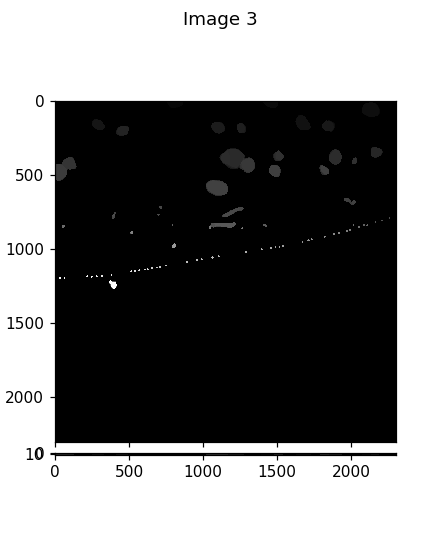

In [14]:
%matplotlib notebook
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [ ]:
watershed_th = 1.4

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_0.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_000.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_000.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.293s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_cor

- Loaded images for channels:['477', '405'] in 1.878s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.887s.
-- corrected illumination for channel 405 in 0.788s.
- Finished illumination correction in 1.708s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_003.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_003_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.078s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.947s.
-- corrected illumination for channel 405 in 0.791s.
- Finished illumination correction in 1.771s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_006.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_006_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.136s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.947s.
-- corrected illumination for channel 477 in 0.792s.
- Finished illumination correction in 1.768s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.062s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.962s.
-- corrected illumination for channel 477 in 0.799s.
- Finished illumination correction in 1.791s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    8.21 -6.37] in 0.442s.
-- drift 1: [ 0.    8.91 -6.17] in 0.460s.
-- drift 2: [-0.01  9.01 -5.97] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.660s.
- Finished warp correction in 8.660s.


-- corrected illumination for channel 637 in 0.911s.
-- corrected illumination for channel 477 in 0.783s.
- Finished illumination correction in 1.724s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    8.52 -7.06] in 0.431s.
-- drift 1: [ 0.    8.54 -7.06] in 0.454s.
-- drift 2: [-0.01  8.56 -7.05] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.628s.
- Finished warp correction in 8.629s.
- run watershed in 157.456s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_12.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_13.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_01

-- drift 1: [ 0.    8.28 -7.2 ] in 0.463s.
-- drift 2: [-0.01  8.73 -7.43] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.668s.
- Finished warp correction in 8.668s.
- run watershed in 115.089s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_15.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_16.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_016.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_016.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_016.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain

- run watershed in 198.675s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_18.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_19.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_019.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_019.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_019.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_019_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.101s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correctio

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_022.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_022.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_022.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_022_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.903s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.966s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.906s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.961s.
-- corrected illumination for channel 405 in 0.792s.
- Finished illumination correction in 1.786s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_025.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_025_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.109s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.951s.
-- corrected illumination for channel 405 in 0.789s.
- Finished illumination correction in 1.796s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_028.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_028_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.137s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.918s.
-- corrected illumination for channel 477 in 0.780s.
- Finished illumination correction in 1.728s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 0.998s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.946s.
-- corrected illumination for channel 477 in 0.783s.
- Finished illumination correction in 1.758s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.64 -7.1 ] in 0.433s.
-- drift 1: [ 0.    7.01 -7.21] in 0.456s.
-- drift 2: [ 0.    6.28 -7.01] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.774s.
- Finished warp correction in 8.775s.


-- corrected illumination for channel 637 in 0.955s.
-- corrected illumination for channel 477 in 0.811s.
- Finished illumination correction in 1.796s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.02  8.61 -7.62] in 0.437s.
-- drift 1: [-0.01  8.7  -7.66] in 0.459s.
-- drift 2: [ 0.    8.77 -7.68] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.657s.
- Finished warp correction in 8.658s.
- run watershed in 186.189s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_34.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_35.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_03

-- drift 1: [-0.02  8.29 -6.83] in 0.453s.
-- drift 2: [-0.01  8.32 -6.76] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.644s.
- Finished warp correction in 8.644s.
- run watershed in 193.792s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_37.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_38.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_038.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_038.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_038.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain

- run watershed in 183.597s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_40.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_41.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_041.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_041.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_041.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_041_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.994s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correctio

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_044.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_044.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_044.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_044_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.902s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.938s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.979s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.961s.
-- corrected illumination for channel 405 in 0.802s.
- Finished illumination correction in 1.795s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_047.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_047_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.243s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.944s.
-- corrected illumination for channel 405 in 0.783s.
- Finished illumination correction in 1.760s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_050.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_050_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.024s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.963s.
-- corrected illumination for channel 477 in 0.799s.
- Finished illumination correction in 1.792s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.138s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.940s.
-- corrected illumination for channel 477 in 0.778s.
- Finished illumination correction in 1.749s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    8.42 -6.84] in 0.430s.
-- drift 1: [ 0.    8.45 -6.82] in 0.454s.
-- drift 2: [-0.01  8.6  -6.86] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.947s.
- Finished warp correction in 8.947s.


-- corrected illumination for channel 637 in 0.953s.
-- corrected illumination for channel 477 in 0.793s.
- Finished illumination correction in 1.775s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.02  8.6  -4.98] in 0.439s.
-- drift 1: [-0.01  8.58 -4.82] in 0.453s.
-- drift 2: [ 0.    8.52 -4.94] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.759s.
- Finished warp correction in 8.759s.
- run watershed in 217.653s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_56.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_57.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_05

-- drift 1: [ 0.    8.18 -7.86] in 0.451s.
-- drift 2: [ 0.    8.15 -7.93] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.746s.
- Finished warp correction in 8.746s.
- run watershed in 199.402s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_59.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_60.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_060.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_060.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_060.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain

- run watershed in 220.054s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_62.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_63.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_063.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_063.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_063.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_063_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.974s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correctio

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_066.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_066.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_066.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_066_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.921s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.958s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.844s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.891s.
-- corrected illumination for channel 405 in 0.795s.
- Finished illumination correction in 1.719s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_069.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_069_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.133s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.949s.
-- corrected illumination for channel 405 in 0.790s.
- Finished illumination correction in 1.771s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_072.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_072_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.086s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.942s.
-- corrected illumination for channel 477 in 0.786s.
- Finished illumination correction in 1.757s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.070s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.949s.
-- corrected illumination for channel 477 in 0.791s.
- Finished illumination correction in 1.769s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.81 -6.73] in 0.432s.
-- drift 1: [-0.01  6.89 -6.67] in 0.454s.
-- drift 2: [-0.01  6.91 -6.62] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.763s.
- Finished warp correction in 8.763s.


-- corrected illumination for channel 637 in 0.950s.
-- corrected illumination for channel 477 in 0.789s.
- Finished illumination correction in 1.768s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  7.22 -6.44] in 0.432s.
-- drift 1: [-0.01  7.21 -6.39] in 0.459s.
-- drift 2: [-0.01  7.27 -6.39] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.763s.
- Finished warp correction in 8.763s.
- run watershed in 189.999s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_78.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_79.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_07

-- drift 1: [-0.01  7.47 -7.63] in 0.461s.
-- drift 2: [-0.01  7.59 -7.64] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.767s.
- Finished warp correction in 8.767s.
- run watershed in 205.735s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_81.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_82.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_082.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_082.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_082.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain

- run watershed in 196.656s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_84.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_85.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_085.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_085.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_085.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_085_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.834s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correctio

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_088.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_088.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_088.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_088_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.981s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.940s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 2.008s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.955s.
-- corrected illumination for channel 405 in 0.797s.
- Finished illumination correction in 1.784s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_091.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_091_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.135s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.956s.
-- corrected illumination for channel 405 in 0.796s.
- Finished illumination correction in 1.808s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_094.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_094_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.048s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.958s.
-- corrected illumination for channel 477 in 0.799s.
- Finished illumination correction in 1.787s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.217s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.946s.
-- corrected illumination for channel 477 in 0.783s.
- Finished illumination correction in 1.761s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    8.6  -6.45] in 0.431s.
-- drift 1: [-0.01  8.49 -6.61] in 0.455s.
-- drift 2: [ 0.    8.52 -6.53] in 0.451s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.757s.
- Finished warp correction in 8.757s.


-- corrected illumination for channel 637 in 0.955s.
-- corrected illumination for channel 477 in 0.796s.
- Finished illumination correction in 1.781s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    7.83 -6.74] in 0.440s.
-- drift 1: [ 0.    7.78 -6.89] in 0.457s.
-- drift 2: [-0.01  7.81 -6.86] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.777s.
- Finished warp correction in 8.777s.
- run watershed in 197.018s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_100.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_101.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.    7.63 -8.35] in 0.461s.
-- drift 2: [ 0.    7.69 -8.38] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.772s.
- Finished warp correction in 8.772s.
- run watershed in 196.855s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_103.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_104.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_104.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_104.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_104.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 187.338s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_106.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_107.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_107.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_107.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_107.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_107_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.882s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_110.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_110.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_110.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_110_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.612s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.939s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 2.404s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.941s.
-- corrected illumination for channel 405 in 0.783s.
- Finished illumination correction in 1.758s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_113.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_113_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.199s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.956s.
-- corrected illumination for channel 405 in 0.801s.
- Finished illumination correction in 1.789s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_116.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_116_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.144s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.961s.
-- corrected illumination for channel 477 in 0.802s.
- Finished illumination correction in 1.792s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.072s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.956s.
-- corrected illumination for channel 477 in 0.800s.
- Finished illumination correction in 1.786s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    7.76 -5.87] in 0.439s.
-- drift 1: [ 0.    7.7  -5.99] in 0.455s.
-- drift 2: [ 0.    7.76 -5.89] in 0.459s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.766s.
- Finished warp correction in 8.766s.


-- corrected illumination for channel 637 in 0.953s.
-- corrected illumination for channel 477 in 0.794s.
- Finished illumination correction in 1.777s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  7.41 -6.69] in 0.439s.
-- drift 1: [-0.02  7.44 -6.62] in 0.461s.
-- drift 2: [-0.01  7.34 -6.69] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.772s.
- Finished warp correction in 8.772s.
- run watershed in 203.345s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_122.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_123.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [-0.01  7.18 -6.5 ] in 0.450s.
-- drift 2: [-0.01  7.24 -6.78] in 0.453s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.774s.
- Finished warp correction in 8.775s.
- run watershed in 165.768s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_125.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_126.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_126.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_126.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_126.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 189.351s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_128.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_129.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_129.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_129.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_129.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_129_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.112s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_132.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_132.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_132.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_132_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.983s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.962s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 2.022s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.948s.
-- corrected illumination for channel 405 in 0.784s.
- Finished illumination correction in 1.764s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_135.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_135_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.499s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.950s.
-- corrected illumination for channel 405 in 0.795s.
- Finished illumination correction in 1.779s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_138.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_138_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.122s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.949s.
-- corrected illumination for channel 477 in 0.793s.
- Finished illumination correction in 1.771s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.221s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.940s.
-- corrected illumination for channel 477 in 0.782s.
- Finished illumination correction in 1.752s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  8.6  -5.82] in 0.434s.
-- drift 1: [ 0.    8.42 -5.91] in 0.455s.
-- drift 2: [-0.01  8.62 -5.64] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.775s.
- Finished warp correction in 8.775s.


-- corrected illumination for channel 637 in 0.938s.
-- corrected illumination for channel 477 in 0.788s.
- Finished illumination correction in 1.755s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    8.01 -5.95] in 0.434s.
-- drift 1: [ 0.    7.95 -5.91] in 0.456s.
-- drift 2: [ 0.    8.06 -6.04] in 0.453s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.773s.
- Finished warp correction in 8.773s.
- run watershed in 175.476s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_144.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_145.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.    7.76 -8.31] in 0.464s.
-- drift 2: [ 0.    7.86 -8.32] in 0.461s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.789s.
- Finished warp correction in 8.789s.
- run watershed in 180.259s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_147.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_148.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_148.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_148.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_148.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 191.458s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_150.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_151.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_151.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_151.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_151.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_151_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.195s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_154.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_154.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_154.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_154_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.126s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.950s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.847s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.937s.
-- corrected illumination for channel 405 in 0.778s.
- Finished illumination correction in 1.747s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_157.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_157_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.272s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.963s.
-- corrected illumination for channel 405 in 0.802s.
- Finished illumination correction in 1.798s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_160.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_160_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.231s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.907s.
-- corrected illumination for channel 477 in 0.799s.
- Finished illumination correction in 1.737s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.119s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.943s.
-- corrected illumination for channel 477 in 0.790s.
- Finished illumination correction in 1.763s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    5.7  -7.48] in 0.437s.
-- drift 1: [ 0.    5.71 -7.67] in 0.458s.
-- drift 2: [ 0.01  5.16 -7.34] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.753s.
- Finished warp correction in 8.753s.


-- corrected illumination for channel 637 in 0.836s.
-- corrected illumination for channel 477 in 0.789s.
- Finished illumination correction in 1.654s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  7.01 -6.86] in 0.437s.
-- drift 1: [ 0.    6.94 -6.87] in 0.453s.
-- drift 2: [ 0.    6.89 -6.93] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.785s.
- Finished warp correction in 8.785s.
- run watershed in 205.753s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_166.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_167.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [-0.01  6.49 -7.68] in 0.461s.
-- drift 2: [ 0.    6.72 -7.52] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.827s.
- Finished warp correction in 8.827s.
- run watershed in 197.886s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_169.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_170.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_170.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_170.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_170.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 198.174s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_172.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_173.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_173.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_173.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_173.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_173_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.906s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_176.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_176.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_176.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_176_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.077s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.945s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 2.092s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.951s.
-- corrected illumination for channel 405 in 0.791s.
- Finished illumination correction in 1.774s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_179.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_179_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.252s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.956s.
-- corrected illumination for channel 405 in 0.793s.
- Finished illumination correction in 1.782s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_182.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_182_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.995s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.957s.
-- corrected illumination for channel 477 in 0.797s.
- Finished illumination correction in 1.784s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.136s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.952s.
-- corrected illumination for channel 477 in 0.796s.
- Finished illumination correction in 1.777s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  7.31 -5.82] in 0.439s.
-- drift 1: [ 0.    7.08 -6.06] in 0.461s.
-- drift 2: [-0.01  7.29 -5.83] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.773s.
- Finished warp correction in 8.773s.


-- corrected illumination for channel 637 in 0.945s.
-- corrected illumination for channel 477 in 0.792s.
- Finished illumination correction in 1.767s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    7.32 -7.24] in 0.435s.
-- drift 1: [ 0.    7.35 -7.14] in 0.456s.
-- drift 2: [ 0.    7.24 -7.33] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.764s.
- Finished warp correction in 8.764s.
- run watershed in 179.968s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_188.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_189.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.    7.75 -7.2 ] in 0.456s.
-- drift 2: [ 0.    7.66 -7.32] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.790s.
- Finished warp correction in 8.790s.
- run watershed in 187.876s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_191.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_192.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_192.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_192.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_192.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 208.845s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_194.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_195.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_195.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_195.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_195.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_195_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.025s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_198.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_198.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_198.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_198_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.102s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.958s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.983s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.960s.
-- corrected illumination for channel 405 in 0.801s.
- Finished illumination correction in 1.795s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_201.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_201_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.077s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.939s.
-- corrected illumination for channel 405 in 0.779s.
- Finished illumination correction in 1.751s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_204.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_204_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.190s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.943s.
-- corrected illumination for channel 477 in 0.786s.
- Finished illumination correction in 1.758s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.184s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.946s.
-- corrected illumination for channel 477 in 0.784s.
- Finished illumination correction in 1.760s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  5.3  -6.77] in 0.433s.
-- drift 1: [ 0.    5.34 -6.83] in 0.461s.
-- drift 2: [ 0.    5.34 -6.79] in 0.453s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.888s.
- Finished warp correction in 8.888s.


-- corrected illumination for channel 637 in 0.938s.
-- corrected illumination for channel 477 in 0.781s.
- Finished illumination correction in 1.748s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  6.43 -5.88] in 0.431s.
-- drift 1: [ 0.    6.68 -5.88] in 0.455s.
-- drift 2: [ 0.    6.76 -5.85] in 0.451s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.738s.
- Finished warp correction in 8.739s.
- run watershed in 172.934s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_210.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_211.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.    7.37 -7.01] in 0.461s.
-- drift 2: [-0.01  7.41 -7.04] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.814s.
- Finished warp correction in 8.814s.
- run watershed in 184.419s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_213.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_214.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_214.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_214.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_214.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 171.797s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_216.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_217.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_217.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_217.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_217.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_217_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.946s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_220.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_220.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_220.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_220_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.149s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.958s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 2.003s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.964s.
-- corrected illumination for channel 405 in 0.805s.
- Finished illumination correction in 1.801s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_223.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_223_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.239s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.957s.
-- corrected illumination for channel 405 in 0.798s.
- Finished illumination correction in 1.787s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_226.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_226_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.091s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.959s.
-- corrected illumination for channel 477 in 0.798s.
- Finished illumination correction in 1.788s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.165s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.949s.
-- corrected illumination for channel 477 in 0.791s.
- Finished illumination correction in 1.769s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  7.54 -6.9 ] in 0.432s.
-- drift 1: [ 0.    7.46 -6.98] in 0.453s.
-- drift 2: [-0.01  7.47 -6.87] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.758s.
- Finished warp correction in 8.758s.


-- corrected illumination for channel 637 in 0.945s.
-- corrected illumination for channel 477 in 0.786s.
- Finished illumination correction in 1.760s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    8.31 -6.05] in 0.434s.
-- drift 1: [ 0.01  8.18 -6.21] in 0.455s.
-- drift 2: [ 0.    8.34 -6.13] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.737s.
- Finished warp correction in 8.737s.
- run watershed in 127.598s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_232.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_233.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.    7.32 -6.17] in 0.455s.
-- drift 2: [ 0.    7.32 -6.19] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.789s.
- Finished warp correction in 8.789s.
- run watershed in 188.086s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_235.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_236.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_236.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_236.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_236.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 209.889s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_238.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_239.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_239.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_239.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_239.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_239_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.900s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_242.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_242.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_242.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_242_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.007s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.962s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.931s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.963s.
-- corrected illumination for channel 405 in 0.802s.
- Finished illumination correction in 1.799s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_245.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_245_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.030s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.959s.
-- corrected illumination for channel 405 in 0.798s.
- Finished illumination correction in 1.790s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_248.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_248_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.159s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.942s.
-- corrected illumination for channel 477 in 0.783s.
- Finished illumination correction in 1.754s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.110s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.955s.
-- corrected illumination for channel 477 in 0.797s.
- Finished illumination correction in 1.781s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  5.49 -7.18] in 0.439s.
-- drift 1: [ 0.    5.52 -7.22] in 0.456s.
-- drift 2: [ 0.01  5.49 -7.23] in 0.453s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.903s.
- Finished warp correction in 8.903s.


-- corrected illumination for channel 637 in 0.958s.
-- corrected illumination for channel 477 in 0.799s.
- Finished illumination correction in 1.787s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.03  5.45 -6.71] in 0.436s.
-- drift 1: [ 0.01  4.78 -7.1 ] in 0.457s.
-- drift 2: [ 0.01  4.55 -7.  ] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.648s.
- Finished warp correction in 8.649s.
- run watershed in 140.763s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_254.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_255.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [-0.01  6.08 -5.99] in 0.457s.
-- drift 2: [-0.01  6.07 -6.03] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.631s.
- Finished warp correction in 8.631s.
- run watershed in 172.584s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_257.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_258.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_258.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_258.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_258.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 207.710s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_260.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_261.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_261.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_261.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_261.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_261_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.883s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_264.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_264.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_264.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_264_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.901s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.954s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.939s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.964s.
-- corrected illumination for channel 405 in 0.805s.
- Finished illumination correction in 1.802s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_267.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_267_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.237s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.949s.
-- corrected illumination for channel 405 in 0.790s.
- Finished illumination correction in 1.772s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_270.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_270_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.092s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.946s.
-- corrected illumination for channel 477 in 0.792s.
- Finished illumination correction in 1.768s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.062s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.943s.
-- corrected illumination for channel 477 in 0.781s.
- Finished illumination correction in 1.755s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.49 -6.18] in 0.432s.
-- drift 1: [ 0.    6.51 -6.22] in 0.449s.
-- drift 2: [-0.01  6.47 -6.21] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.639s.
- Finished warp correction in 8.639s.


-- corrected illumination for channel 637 in 0.953s.
-- corrected illumination for channel 477 in 0.797s.
- Finished illumination correction in 1.779s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.79 -5.57] in 0.446s.
-- drift 1: [ 0.    6.76 -5.54] in 0.456s.
-- drift 2: [ 0.    6.84 -5.6 ] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.673s.
- Finished warp correction in 8.673s.
- run watershed in 190.853s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_276.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_277.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.01  6.59 -4.73] in 0.456s.
-- drift 2: [ 0.01  6.63 -4.8 ] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.665s.
- Finished warp correction in 8.665s.
- run watershed in 170.265s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_279.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_280.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_280.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_280.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_280.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 190.906s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_282.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_283.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_283.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_283.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_283.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_283_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.881s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_286.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_286.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_286.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_286_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.837s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.951s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 2.141s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.959s.
-- corrected illumination for channel 405 in 0.806s.
- Finished illumination correction in 1.798s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_289.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_289_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.046s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.979s.
-- corrected illumination for channel 405 in 0.817s.
- Finished illumination correction in 1.829s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_292.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_292_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.003s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.887s.
-- corrected illumination for channel 477 in 0.806s.
- Finished illumination correction in 1.723s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.073s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.952s.
-- corrected illumination for channel 477 in 0.804s.
- Finished illumination correction in 1.786s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    5.61 -6.15] in 0.437s.
-- drift 1: [ 0.    5.65 -6.11] in 0.456s.
-- drift 2: [ 0.    5.63 -6.08] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.639s.
- Finished warp correction in 8.639s.


-- corrected illumination for channel 637 in 0.816s.
-- corrected illumination for channel 477 in 0.795s.
- Finished illumination correction in 1.641s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  4.85 -5.74] in 0.447s.
-- drift 1: [ 0.    4.97 -5.67] in 0.454s.
-- drift 2: [ 0.01  4.93 -5.71] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.665s.
- Finished warp correction in 8.665s.
- run watershed in 180.610s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_298.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_299.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.    6.79 -5.57] in 0.456s.
-- drift 2: [ 0.    7.04 -5.73] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.671s.
- Finished warp correction in 8.671s.
- run watershed in 178.861s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_301.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_302.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_302.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_302.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_302.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 203.292s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_304.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_305.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_305.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_305.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_305.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_305_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.210s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_308.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_308.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_308.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_308_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.020s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.940s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 2.061s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.943s.
-- corrected illumination for channel 405 in 0.784s.
- Finished illumination correction in 1.760s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_311.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_311_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.154s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.949s.
-- corrected illumination for channel 405 in 0.784s.
- Finished illumination correction in 1.766s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_314.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_314_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.106s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.951s.
-- corrected illumination for channel 477 in 0.786s.
- Finished illumination correction in 1.766s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.006s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.948s.
-- corrected illumination for channel 477 in 0.786s.
- Finished illumination correction in 1.763s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.86 -6.3 ] in 0.438s.
-- drift 1: [ 0.    6.76 -6.33] in 0.453s.
-- drift 2: [ 0.    6.81 -6.39] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.630s.
- Finished warp correction in 8.630s.


-- corrected illumination for channel 637 in 0.941s.
-- corrected illumination for channel 477 in 0.783s.
- Finished illumination correction in 1.753s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.97 -6.15] in 0.433s.
-- drift 1: [-0.01  6.94 -6.16] in 0.449s.
-- drift 2: [ 0.    6.93 -6.08] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.607s.
- Finished warp correction in 8.607s.
- run watershed in 207.079s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_320.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_321.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.03  6.92 -5.65] in 0.454s.
-- drift 2: [ 0.    7.11 -5.49] in 0.450s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.600s.
- Finished warp correction in 8.601s.
- run watershed in 92.891s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_323.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_324.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_324.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_324.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_324.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrai

- run watershed in 192.374s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_326.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_327.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_327.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_327.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_327.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_327_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.956s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_330.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_330.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_330.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_330_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.957s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.951s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.965s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.948s.
-- corrected illumination for channel 405 in 0.782s.
- Finished illumination correction in 1.763s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_333.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_333_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.450s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.948s.
-- corrected illumination for channel 405 in 0.788s.
- Finished illumination correction in 1.769s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_336.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_336_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.094s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.949s.
-- corrected illumination for channel 477 in 0.789s.
- Finished illumination correction in 1.768s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.023s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.938s.
-- corrected illumination for channel 477 in 0.789s.
- Finished illumination correction in 1.756s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.   -7.19] in 0.431s.
-- drift 1: [ 0.    5.88 -7.19] in 0.458s.
-- drift 2: [ 0.    5.93 -7.2 ] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.644s.
- Finished warp correction in 8.644s.


-- corrected illumination for channel 637 in 0.937s.
-- corrected illumination for channel 477 in 0.780s.
- Finished illumination correction in 1.749s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    5.76 -5.75] in 0.429s.
-- drift 1: [ 0.    5.78 -5.72] in 0.449s.
-- drift 2: [ 0.    5.79 -5.77] in 0.451s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.643s.
- Finished warp correction in 8.644s.
- run watershed in 203.084s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_342.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_343.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 0: [ 0.    5.63 -5.79] in 0.438s.
-- drift 1: [ 0.    5.74 -6.13] in 0.457s.
-- drift 2: [ 0.    5.69 -5.89] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.669s.
- Finished warp correction in 8.669s.
- run watershed in 168.333s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_345.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_346.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_346.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_346.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_346.dax
- New save file: /lab/weiss

-- corrected warp for channel 637 in 8.672s.
- Finished warp correction in 8.672s.
- run watershed in 207.329s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_348.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_349.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_349.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_349.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_349.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_349_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.859s.
- Correct illumination for channels: ['477', '405']
-

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_352.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_352.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_352.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_352_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.971s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.899s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.913s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.960s.
-- corrected illumination for channel 405 in 0.798s.
- Finished illumination correction in 1.790s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_355.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_355_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.011s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.950s.
-- corrected illumination for channel 405 in 0.792s.
- Finished illumination correction in 1.774s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_358.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_358_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.015s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.945s.
-- corrected illumination for channel 477 in 0.787s.
- Finished illumination correction in 1.762s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.185s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.953s.
-- corrected illumination for channel 477 in 0.799s.
- Finished illumination correction in 1.781s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  6.15 -5.47] in 0.435s.
-- drift 1: [-0.01  6.1  -5.56] in 0.456s.
-- drift 2: [ 0.    5.99 -5.6 ] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.670s.
- Finished warp correction in 8.671s.


-- corrected illumination for channel 637 in 0.947s.
-- corrected illumination for channel 477 in 0.792s.
- Finished illumination correction in 1.771s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.87 -5.27] in 0.434s.
-- drift 1: [-0.01  6.94 -5.26] in 0.455s.
-- drift 2: [-0.01  6.93 -5.26] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.671s.
- Finished warp correction in 8.671s.
- run watershed in 189.850s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_364.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_365.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.    6.72 -5.73] in 0.459s.
-- drift 2: [-0.01  6.82 -5.54] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.635s.
- Finished warp correction in 8.635s.
- run watershed in 174.194s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_367.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_368.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_368.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_368.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_368.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 98.795s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_370.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_371.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_371.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_371.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_371.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_371_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.354s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correcti

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_374.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_374.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_374.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_374_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.085s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.936s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.965s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.849s.
-- corrected illumination for channel 405 in 0.789s.
- Finished illumination correction in 1.677s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_377.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_377_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.162s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.948s.
-- corrected illumination for channel 405 in 0.792s.
- Finished illumination correction in 1.772s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_380.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_380_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.101s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.950s.
-- corrected illumination for channel 477 in 0.789s.
- Finished illumination correction in 1.768s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.322s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.948s.
-- corrected illumination for channel 477 in 0.791s.
- Finished illumination correction in 1.770s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.39 -5.51] in 0.436s.
-- drift 1: [ 0.    6.43 -5.33] in 0.455s.
-- drift 2: [ 0.    6.44 -5.37] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.669s.
- Finished warp correction in 8.669s.


-- corrected illumination for channel 637 in 0.954s.
-- corrected illumination for channel 477 in 0.792s.
- Finished illumination correction in 1.777s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  5.79 -5.82] in 0.433s.
-- drift 1: [ 0.01  5.66 -5.86] in 0.454s.
-- drift 2: [ 0.   5.7 -5.9] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.645s.
- Finished warp correction in 8.645s.
- run watershed in 159.292s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_386.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_387.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_387

-- drift 1: [ 0.    5.78 -4.28] in 0.457s.
-- drift 2: [ 0.    5.85 -4.29] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.661s.
- Finished warp correction in 8.661s.
- run watershed in 180.111s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_389.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_390.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_390.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_390.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_390.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 177.884s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_392.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_393.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_393.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_393.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_393.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_393_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.951s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_396.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_396.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_396.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_396.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_396_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.994s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_c

- Loaded images for channels:['477', '405'] in 1.954s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.945s.
-- corrected illumination for channel 405 in 0.779s.
- Finished illumination correction in 1.756s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_399.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_399_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.042s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.965s.
-- corrected illumination for channel 405 in 0.810s.
- Finished illumination correction in 1.808s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_402.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_402_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.053s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.969s.
-- corrected illumination for channel 477 in 0.809s.
- Finished illumination correction in 1.808s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.048s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.944s.
-- corrected illumination for channel 477 in 0.784s.
- Finished illumination correction in 1.759s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.88 -5.07] in 0.438s.
-- drift 1: [ 0.   6.8 -5.1] in 0.459s.
-- drift 2: [ 0.    6.84 -5.13] in 0.459s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.790s.
- Finished warp correction in 8.791s.
- r

-- corrected illumination for channel 637 in 0.961s.
-- corrected illumination for channel 477 in 0.801s.
- Finished illumination correction in 1.792s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.21 -4.97] in 0.436s.
-- drift 1: [ 0.    6.22 -5.02] in 0.462s.
-- drift 2: [ 0.    6.25 -5.1 ] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.678s.
- Finished warp correction in 8.678s.
- run watershed in 193.268s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_408.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_409.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [-0.01  6.74 -5.49] in 0.453s.
-- drift 2: [-0.01  6.79 -5.23] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.640s.
- Finished warp correction in 8.640s.
- run watershed in 212.303s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_411.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_412.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_412.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_412.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_412.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 201.461s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_414.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_415.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_415.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_415.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_415.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_415_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.957s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_418.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_418.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_418.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_418_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.018s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.962s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 2.055s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.952s.
-- corrected illumination for channel 405 in 0.789s.
- Finished illumination correction in 1.774s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_421.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_421_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.012s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.968s.
-- corrected illumination for channel 405 in 0.809s.
- Finished illumination correction in 1.809s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_424.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_424_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.470s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.960s.
-- corrected illumination for channel 477 in 0.804s.
- Finished illumination correction in 1.794s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.086s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.957s.
-- corrected illumination for channel 477 in 0.798s.
- Finished illumination correction in 1.785s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  5.66 -5.48] in 0.437s.
-- drift 1: [ 0.    5.61 -5.44] in 0.456s.
-- drift 2: [ 0.    5.63 -5.48] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.790s.
- Finished warp correction in 8.790s.


-- corrected illumination for channel 637 in 0.954s.
-- corrected illumination for channel 477 in 0.794s.
- Finished illumination correction in 1.780s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  5.71 -4.7 ] in 0.435s.
-- drift 1: [ 0.    5.67 -4.86] in 0.460s.
-- drift 2: [ 0.    5.72 -4.92] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.681s.
- Finished warp correction in 8.681s.
- run watershed in 200.004s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_430.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_431.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.    5.29 -5.24] in 0.454s.
-- drift 2: [ 0.    5.68 -5.09] in 0.453s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.655s.
- Finished warp correction in 8.655s.
- run watershed in 204.549s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_433.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_434.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_434.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_434.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_434.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 233.043s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_436.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_437.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_437.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_437.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_437.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_437_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.800s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_440.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_440.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_440.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_440_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.805s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.961s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 1.843s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.958s.
-- corrected illumination for channel 405 in 0.799s.
- Finished illumination correction in 1.788s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_443.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_443_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.018s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.970s.
-- corrected illumination for channel 405 in 0.808s.
- Finished illumination correction in 1.811s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_446.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_446_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.193s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.968s.
-- corrected illumination for channel 477 in 0.810s.
- Finished illumination correction in 1.809s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.014s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.949s.
-- corrected illumination for channel 477 in 0.788s.
- Finished illumination correction in 1.767s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.8  -4.73] in 0.435s.
-- drift 1: [ 0.    6.75 -4.74] in 0.456s.
-- drift 2: [ 0.    6.8  -4.76] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.758s.
- Finished warp correction in 8.758s.


-- corrected illumination for channel 637 in 0.959s.
-- corrected illumination for channel 477 in 0.800s.
- Finished illumination correction in 1.789s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  6.03 -5.28] in 0.437s.
-- drift 1: [ 0.    6.13 -5.57] in 0.456s.
-- drift 2: [ 0.    5.88 -5.26] in 0.486s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.771s.
- Finished warp correction in 8.771s.
- run watershed in 182.957s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_452.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_453.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [-0.01  5.86 -4.12] in 0.458s.
-- drift 2: [ 0.    6.05 -4.23] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.782s.
- Finished warp correction in 8.783s.
- run watershed in 163.431s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_455.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_456.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_456.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_456.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_456.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 208.722s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_458.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_459.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_459.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_459.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_459.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_459_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.912s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_462.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_462.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_462.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_462_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.034s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.951s.
-- corrected illumination for channel 405 in 

- Loaded images for channels:['477', '405'] in 2.025s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.959s.
-- corrected illumination for channel 405 in 0.797s.
- Finished illumination correction in 1.789s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_465.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_465_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.073s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- 

-- corrected illumination for channel 477 in 0.949s.
-- corrected illumination for channel 405 in 0.788s.
- Finished illumination correction in 1.771s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_468.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_468_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.081s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.940s.
-- corrected illumination for channel 477 in 0.786s.
- Finished illumination correction in 1.755s.
+ Calculate d

- Loaded images for channels:['637', '477'] in 1.032s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.954s.
-- corrected illumination for channel 477 in 0.797s.
- Finished illumination correction in 1.780s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  5.93 -4.29] in 0.436s.
-- drift 1: [-0.01  5.88 -4.23] in 0.456s.
-- drift 2: [ 0.    5.89 -4.43] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.748s.
- Finished warp correction in 8.748s.


-- corrected illumination for channel 637 in 0.963s.
-- corrected illumination for channel 477 in 0.806s.
- Finished illumination correction in 1.798s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    6.03 -4.1 ] in 0.439s.
-- drift 1: [ 0.    6.08 -4.09] in 0.460s.
-- drift 2: [ 0.    6.14 -4.1 ] in 0.459s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.750s.
- Finished warp correction in 8.750s.
- run watershed in 201.698s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_474.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_475.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_

-- drift 1: [ 0.    6.03 -4.17] in 0.455s.
-- drift 2: [ 0.    5.71 -4.48] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.778s.
- Finished warp correction in 8.778s.
- run watershed in 181.665s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_477.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_478.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_478.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_478.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_478.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbra

- run watershed in 206.156s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/watershed/segmentation_label_480.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/Segmentation/segmentation_label_481.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_481.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_481.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_481.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_481_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.029s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_484.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H11M12/Conv_zscan_484.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_484.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240414-EAEbrain_MF5/H0M1/Conv_zscan_484_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.997s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.963s.
-- corrected illumination for channel 405 in 

<IPython.core.display.Javascript object>


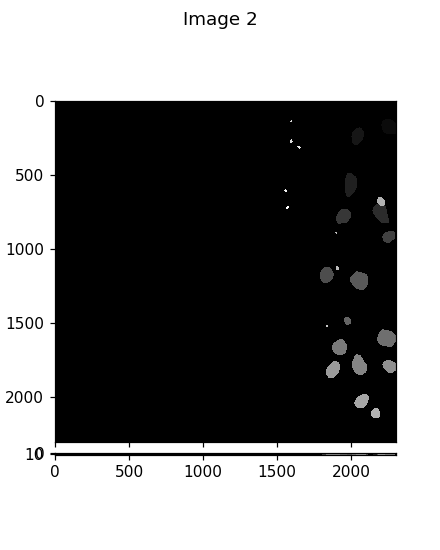

In [21]:
imshow_mark_3d([new_labels, corr_labels3d])

# Copy segmentation labels

In [24]:
# Copy segmentation labels
from shutil import copyfile
data_master_folder = r'/lab/weissman_imaging/puzheng/MERFISH_data'
analysis_master_folder = r'/lab/weissman_imaging/puzheng/MERFISH_analysis'
print(os.listdir(data_master_folder))
experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
for _fd in os.listdir(data_master_folder):
    if experiment_date in _fd:
        break
analysis_folder = os.path.join(analysis_master_folder, _fd)
print(analysis_folder)

['20240404-untreatedCord_MF5', '.DS_Store']
20240404
/lab/weissman_imaging/puzheng/MERFISH_analysis/20240404-untreatedCord_MF5


In [25]:
segmentation_target_folder = os.path.join(analysis_folder, 'CellPoseSegment', 'segmentation_label')
print(segmentation_target_folder)
if not os.path.exists(segmentation_target_folder):
    os.makedirs(segmentation_target_folder)
# copy
seg_label_filenames = [os.path.join(watershed_folder, _f) 
                       for _f in os.listdir(watershed_folder) 
                       if 'segmentation_label' in _f and '.npy' in _f]

for _f in seg_label_filenames:
    print(os.path.basename(_f))
    copyfile(_f, os.path.join(segmentation_target_folder, os.path.basename(_f)))

/lab/weissman_imaging/puzheng/MERFISH_analysis/20240404-untreatedCord_MF5/CellPoseSegment/segmentation_label
segmentation_label_0.npy
segmentation_label_1.npy
segmentation_label_2.npy
segmentation_label_3.npy
segmentation_label_4.npy
segmentation_label_5.npy
segmentation_label_6.npy
segmentation_label_7.npy
segmentation_label_8.npy
segmentation_label_9.npy
segmentation_label_10.npy
segmentation_label_11.npy
segmentation_label_12.npy
segmentation_label_13.npy
segmentation_label_14.npy
segmentation_label_15.npy
segmentation_label_16.npy
segmentation_label_17.npy
segmentation_label_18.npy
segmentation_label_19.npy
segmentation_label_20.npy
segmentation_label_21.npy
segmentation_label_22.npy
segmentation_label_23.npy
segmentation_label_24.npy
segmentation_label_25.npy
segmentation_label_26.npy
segmentation_label_27.npy
segmentation_label_28.npy
segmentation_label_29.npy
segmentation_label_30.npy
segmentation_label_31.npy
segmentation_label_32.npy
segmentation_label_33.npy
segmentation_labe

In [26]:
len(seg_label_filenames)

128

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')